In [ ]:

#hello all

import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from google.colab import files

Using TensorFlow backend.


Upload Files

In [ ]:
plane_images = files.upload()

Saving PlaneImages.zip to PlaneImages.zip


In [ ]:
plane_annot = files.upload()

Saving annotations.zip to annotations.zip


Unzip the data

In [ ]:
!unzip PlaneImages.zip
!unzip annotations.zip

Archive:  PlaneImages.zip
   creating: Images/
  inflating: Images/airplane_286.jpg  
  inflating: Images/airplane_029.txt  
  inflating: Images/airplane_030.txt  
  inflating: Images/airplane_287.jpg  
  inflating: Images/airplane_288.jpg  
  inflating: Images/airplane_032.txt  
  inflating: Images/airplane_289.jpg  
  inflating: Images/airplane_035.txt  
  inflating: Images/airplane_290.jpg  
  inflating: Images/airplane_036.txt  
  inflating: Images/airplane_291.jpg  
  inflating: Images/airplane_037.txt  
  inflating: Images/airplane_292.jpg  
  inflating: Images/airplane_038.txt  
  inflating: Images/airplane_303.jpg  
  inflating: Images/airplane_055.txt  
  inflating: Images/airplane_304.jpg  
  inflating: Images/airplane_056.txt  
  inflating: Images/airplane_305.jpg  
  inflating: Images/airplane_057.txt  
  inflating: Images/airplane_306.jpg  
  inflating: Images/airplane_058.txt  
  inflating: Images/airplane_307.jpg  
  inflating: Images/airplane_059.txt  
  inflating: Imag

In [ ]:
path = "Images"
annot = "Airplanes_Annotations_BBox_733"

airplane_693.jpg


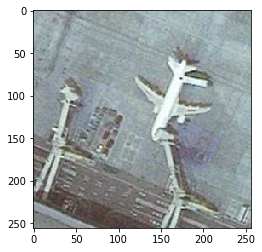

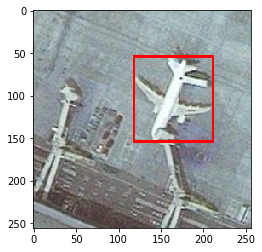

In [ ]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

In [ ]:
cv2.setUseOptimized(True);

In [ ]:
im = cv2.imread(os.path.join(path,"42850.jpg"))

Try Selective Search On An Image

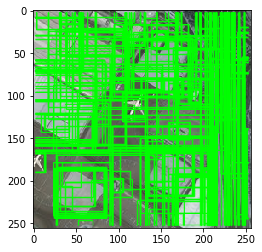

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [ ]:
train_images=[]
train_labels=[]

In [ ]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

Preprocess Data

In [ ]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
    #                             print("dsad ",counter)
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
    #                                 print("asss ",falsecounter)
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    #             print(len(train_images), len(train_labels))
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

            


(0, 'airplane_693.jpg')
(1, 'airplane_450.jpg')
(2, 'airplane_616.jpg')
inside
(3, 'airplane_429.jpg')
(5, 'airplane_445.jpg')
(6, 'airplane_378.jpg')
(7, 'airplane_237.jpg')
(8, 'airplane_495.jpg')
(9, 'airplane_610.jpg')
(10, 'airplane_034.jpg')
(11, 'airplane_299.jpg')
(12, 'airplane_077.jpg')
(13, 'airplane_103.jpg')
(14, 'airplane_310.jpg')
(15, 'airplane_163.jpg')
(16, 'airplane_688.jpg')
(17, 'airplane_048.jpg')
(18, 'airplane_095.jpg')
(19, 'airplane_062.jpg')
inside
(20, 'airplane_413.jpg')
(21, 'airplane_145.jpg')
(22, 'airplane_151.jpg')
inside
(23, 'airplane_388.jpg')
inside
(24, 'airplane_242.jpg')
(25, 'airplane_601.jpg')
(26, 'airplane_098.jpg')
(27, 'airplane_086.jpg')
(28, 'airplane_650.jpg')
(29, 'airplane_628.jpg')
(30, 'airplane_282.jpg')
(31, 'airplane_645.jpg')
inside
(33, 'airplane_328.jpg')
inside
(34, 'airplane_635.jpg')
(35, 'airplane_382.jpg')
inside
(36, 'airplane_398.jpg')
(37, 'airplane_291.jpg')
inside
(38, 'airplane_240.jpg')
(39, 'airplane_037.jpg')
(40

covert dataset to numpy array

In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [ ]:
# del(train_images)
# del(train_labels)

In [ ]:
X_new.shape

(30229, 224, 224, 3)

Save the dataset so that we dont need to compute it again.

In [ ]:
np.save('data.npy', X_new)
np.save('datalabel.npy', y_new)

Load the data from the numpy array

In [ ]:
# X_new = np.load('data.npy')
# y_new = np.load('datalabel.npy')

In [ ]:
X_new.shape

(30229, 224, 224, 3)

1


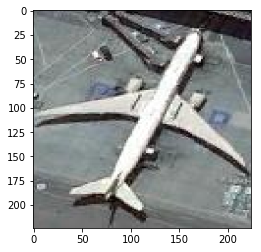

In [ ]:
plt.imshow(X_new[150])
print(y_new[150])

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from keras.applications.vgg16 import VGG16

Loading Imagenet weights

In [ ]:
vggmodel = VGG16(weights='imagenet', include_top=True)

W1007 08:13:39.576653 139767251769216 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1007 08:13:39.620769 139767251769216 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1007 08:13:39.627836 139767251769216 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1007 08:13:39.799808 139767251769216 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1007 08:13:43.648804 139767251769216 deprecation_wrapp

In [ ]:
vggmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Initializing transfer learning and freezing layers

In [ ]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [ ]:
X= vggmodel.layers[-2].output

In [ ]:
predictions = Dense(2, activation="softmax")(X)

In [ ]:
model_final = Model(input = vggmodel.input, output = predictions)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001)

Compiling new model

In [ ]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

W1007 08:14:01.255281 139767251769216 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [ ]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
del vggmodel

In [ ]:
from sklearn.preprocessing import LabelBinarizer

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super(MyLabelBinarizer,self).transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y

    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [ ]:
Y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [ ]:
del(y_new)

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

((27206, 224, 224, 3), (3023, 224, 224, 3), (27206, 2), (3023, 2))


In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

In [ ]:
# X_train = np.load('X_train.npy')
# X_test = np.load('X_test.npy')
# y_train = np.load('y_train.npy')
# y_test = np.load('y_test.npy')

In [ ]:
del X_new

In [ ]:
del Y

Create Dataset

In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)

In [ ]:
del X_train
del y_train

In [ ]:
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
del X_test
del y_test

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [ ]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
tboard = TensorBoard(log_dir='./ieeercnn_vgg16_log',write_graph=True, write_images=False, write_grads=True)

Train Model

In [ ]:
model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early,tboard])

W1007 08:17:19.852979 139767251769216 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1007 08:17:22.918256 139767251769216 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W1007 08:17:22.919962 139767251769216 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/1000
10/10 [==============================] - 13s 1s/step - loss: 5.0583 - acc: 0.6219 - val_loss: 4.0295 - val_acc: 0.7500

Epoch 00001: val_loss improved from inf to 4.02952, saving model to ieeercnn_vgg16_1.h5
Epoch 2/1000
10/10 [==============================] - 5s 546ms/step - loss: 4.8354 - acc: 0.7000 - val_loss: 6.0443 - val_acc: 0.6250

Epoch 00002: val_loss did not improve from 4.02952
Epoch 3/1000
10/10 [==============================] - 5s 538ms/step - loss: 4.8858 - acc: 0.6969 - val_loss: 6.5480 - val_acc: 0.5938

Epoch 00003: val_loss did not improve from 4.02952
Epoch 4/1000
10/10 [==============================] - 5s 539ms/step - loss: 5.3391 - acc: 0.6688 - val_loss: 5.0369 - val_acc: 0.6875

Epoch 00004: val_loss did not improve from 4.02952
Epoch 5/1000
10/10 [==============================] - 5s 537ms/step - loss: 4.5836 - acc: 0.7156 - val_loss: 4.5332 - val_acc: 0.7188

Epoch 00005: val_loss did not improve from 4.02952
Epoch 6/1000
10/10 [===============

KeyboardInterrupt: ignored

Load Model

In [ ]:
from keras.models import load_model

In [ ]:
model = files.upload()

In [ ]:
model_final = load_model("model_vgg16.h5")

View Output

In [ ]:
z=0
for e,i in enumerate(os.listdir(path)):
    if not i.endswith(".txt") and z < 15:
        if i.startswith("4"):
            z += 1
            img = cv2.imread(os.path.join(path,i))
            ss.setBaseImage(img)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = img.copy()
            for e,result in enumerate(ssresults):
                if e < 2000:
                    x,y,w,h = result
                    timage = imout[y:y+h,x:x+w]
                    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                    img = np.expand_dims(resized, axis=0)
                    out= model_final.predict(img)
                    if out[0][0] > 0.65:
                        cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
            plt.figure()
            plt.imshow(imout)
            # plt.savefig('foo1'+str(z)+'.png')